<a href="https://colab.research.google.com/github/ktasha45/python/blob/master/notebook/dacon/imageclassify/dacon_image_classify_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

references  
https://blog.promedius.ai/pytorch_dataloader_1/  
data  
https://dacon.io/competitions/official/235874/codeshare/4549?page=1&dtype=recent

# unzip, import

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls -al /gdrive/MyDrive/tmp/image.zip
!cp /gdrive/MyDrive/tmp/image.zip ./
!unzip image.zip

In [18]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils import data
from PIL import Image
from torchvision import transforms 
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import time

# data loading, data split(stratify)

In [3]:
def make_file_list(path):
  file_list = list()
  label_list = list()
  label_dic = {}
  path = path
  for i, dir in enumerate(glob(path + '*')):
    label_dic[dir.split('/')[2]] = i
    for file_path in tqdm(sorted(glob(dir + '/*'))):
      file_list.append(file_path)
      label_list.append(i)
  return label_dic, file_list, label_list

label_dic, file_list, label_list = make_file_list(path = './train/')

100%|██████████| 5000/5000 [00:00<00:00, 2187952.01it/s]


In [4]:
print(file_list[5002])
print(label_list[5002])
print(label_list[5003])
print(label_dic)

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(file_list, label_list, test_size=0.1, shuffle=True, stratify=label_list, random_state=34) # 층화 무작위 추출

./train/automobile/0002.jpg
1
1
{'cat': 0, 'automobile': 1, 'airplane': 2, 'ship': 3, 'dog': 4, 'deer': 5, 'frog': 6, 'bird': 7, 'truck': 8, 'horse': 9}


In [5]:
print(len(x_train))
print(len(y_train))
print(len(x_valid))
print(len(y_valid))

45000
45000
5000
5000


(array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

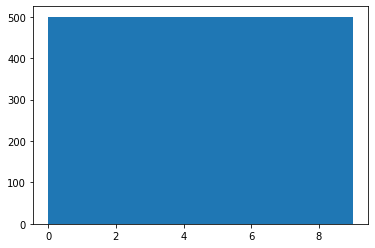

In [6]:
plt.hist(y_valid) # 층화 무작위

# define dataset, dataloader

In [7]:
class ImageTransform():
  def __init__(self):
    self.data_transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)


class Img_Dataset(data.Dataset):
  def __init__(self, file_list, transform):
    self.file_list = file_list
    self.transform = transform

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):
    img_path = self.file_list[index] # 데이터셋에서 파일 하나를 특정
    img = Image.open(img_path)
    img_transformed = self.transform(img)

    label = label_dic[img_path.split('/')[2]] # 파일명으로부터 라벨명 추출

    return img_transformed, label

train_dataset = Img_Dataset(file_list=x_train, transform=ImageTransform())
test_dataset = Img_Dataset(file_list=x_valid, transform=ImageTransform())
#train_dataset = Img_Dataset(file_list=file_list, transform=transforms.ToTensor())

In [8]:
print(train_dataset.__len__())
print(test_dataset.__len__())

45000
5000


In [9]:
print(train_dataset.__getitem__(0)[0])
print(train_dataset.__getitem__(0)[0].shape)

tensor([[[0.0235, 0.0471, 0.0745,  ..., 0.0941, 0.0902, 0.1059],
         [0.0784, 0.0667, 0.0667,  ..., 0.1294, 0.1137, 0.1137],
         [0.0745, 0.0510, 0.0667,  ..., 0.1020, 0.1059, 0.1176],
         ...,
         [0.1490, 0.1176, 0.0980,  ..., 0.4275, 0.4118, 0.4000],
         [0.1804, 0.1490, 0.1294,  ..., 0.4431, 0.4314, 0.4275],
         [0.1843, 0.1608, 0.1608,  ..., 0.4275, 0.4196, 0.4196]],

        [[0.0471, 0.0627, 0.0824,  ..., 0.0784, 0.0667, 0.0824],
         [0.1020, 0.0824, 0.0745,  ..., 0.1137, 0.0902, 0.0902],
         [0.0980, 0.0745, 0.0863,  ..., 0.0863, 0.0824, 0.0941],
         ...,
         [0.1843, 0.1529, 0.1333,  ..., 0.4549, 0.4392, 0.4314],
         [0.2078, 0.1765, 0.1569,  ..., 0.4745, 0.4667, 0.4627],
         [0.2157, 0.1922, 0.1922,  ..., 0.4588, 0.4549, 0.4549]],

        [[0.0392, 0.0588, 0.0706,  ..., 0.0667, 0.0667, 0.0824],
         [0.0941, 0.0784, 0.0627,  ..., 0.1020, 0.0902, 0.0902],
         [0.0824, 0.0588, 0.0706,  ..., 0.0824, 0.0824, 0.

# data visualization

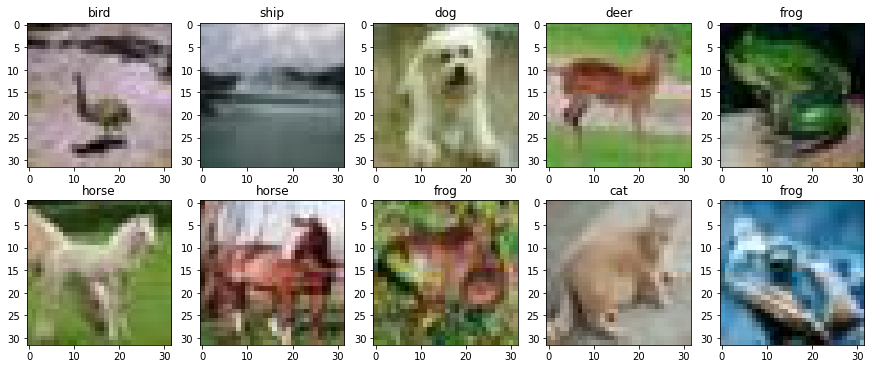

In [10]:
%matplotlib inline

train_dataloader = data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=512)

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

def get_key(val):
  for key, value in label_dic.items():
    if val == value:
      return key

plt.figure(figsize=(15, 6))

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.title(get_key(images[1][i]))
  plt.imshow(to_pil_image(images[0][i]))

tensor([0.1647, 0.1569, 0.1059,  ..., 0.5216, 0.4667, 0.4627])


(array([  7.,   7.,   7.,   4.,  10.,  18.,  22.,  30.,  24.,  24.,  31.,
         30.,  36.,  28.,  44.,  31.,  47.,  34.,  43.,  30.,  40.,  30.,
         42.,  27.,  42.,  43.,  44.,  49.,  57.,  69.,  77., 121., 121.,
        189., 143., 236., 209., 208., 157., 183., 119., 118.,  61.,  65.,
         33.,  30.,  19.,  20.,   7.,   6.]),
 array([0.        , 0.01756863, 0.03513725, 0.05270588, 0.07027451,
        0.08784313, 0.10541177, 0.12298039, 0.14054902, 0.15811765,
        0.17568627, 0.1932549 , 0.21082354, 0.22839215, 0.24596079,
        0.26352942, 0.28109804, 0.29866666, 0.3162353 , 0.33380392,
        0.35137254, 0.3689412 , 0.3865098 , 0.40407842, 0.42164707,
        0.4392157 , 0.4567843 , 0.47435296, 0.49192157, 0.5094902 ,
        0.52705884, 0.5446274 , 0.5621961 , 0.5797647 , 0.5973333 ,
        0.61490196, 0.6324706 , 0.6500392 , 0.66760784, 0.6851765 ,
        0.7027451 , 0.7203137 , 0.7378824 , 0.75545096, 0.7730196 ,
        0.79058826, 0.80815685, 0.8257255 , 0.

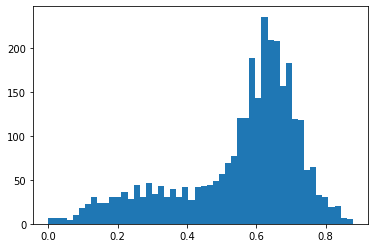

In [11]:
%matplotlib inline

print(images[0][0].flatten())
plt.hist(images[0][0].flatten(), bins = 50)

# define model

In [12]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [13]:
from torch import nn

class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.linear_relu_stack = nn.Sequential(
      nn.Conv2d(3,32,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32,64,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Dropout(0.2),

      nn.Conv2d(64,128,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128,128,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Dropout(0.2),

      nn.Conv2d(128,256,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(256,256,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Dropout(0.2),

      nn.Conv2d(256,128,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128,128,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Dropout(0.2),
      
      nn.Conv2d(128,64,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64,64,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Dropout(0.2),

      nn.Conv2d(64,64,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64,64,kernel_size=2,stride=1,padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Dropout(0.2),

      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(),
      nn.Linear(64, 32),
      nn.BatchNorm1d(32),
      nn.ReLU(),

      nn.Linear(32, 16),
      nn.BatchNorm1d(16),
      nn.ReLU(),
      nn.Dropout(0.5),

      nn.Linear(16, 10)
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [14]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Drop

# define earlystopping

In [15]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# train model

In [16]:
# def test_loop(dataloader, model, loss_fn):
#   size = len(dataloader.dataset)
#   num_batches = len(dataloader)
#   test_loss, correct = 0, 0

#   with torch.no_grad():
#     for X, y in dataloader:
#       X = X.to(device)
#       y = y.to(device)
#       pred = model(X)
#       test_loss += loss_fn(pred, y).item()
#       correct += (pred.argmax(1) == y).type(torch.float).sum().item()

#   test_loss /= num_batches
#   correct /= size
#   print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


def train_loop(model, patience, loss_fn, optimizer, n_epochs):
  train_losses = []
  valid_losses = []
  avg_train_losses = []
  avg_valid_losses = []

  early_stopping = EarlyStopping(patience = patience, verbose = True)

  for epoch in range(1, n_epochs + 1):
    start_time = time.time()
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
      X = X.to(device)
      y = y.to(device)

      # Compute prediction and loss
      pred = model(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())
      print("{} - {}".format(epoch, batch))

    model.eval()
    for data, target in test_dataloader:
      data = data.to(device)
      target = target.to(device)

      output = model(data)
      loss = loss_fn(output, target)
      # record validation loss
      valid_losses.append(loss.item())

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(n_epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                  f'train_loss: {train_loss:.5f} ' +
                  f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)

    train_losses = []
    valid_losses = []

    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    end_time = time.time()
    print('time: %20ds' % (end_time - start_time))

  model.load_state_dict(torch.load('checkpoint.pt'))
  return  model, avg_train_losses, avg_valid_losses

learning_rate = 0.001
batch_size = 512
epochs = 100
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
patience = 20
n_epochs = 100

model, train_loss, valid_loss = train_loop(model, patience, loss_fn, optimizer, n_epochs)

# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(train_dataloader, model, loss_fn, optimizer)
#     test_loop(test_dataloader, model, loss_fn)
# print("Done!")

[  1/100] train_loss: 2.17458 valid_loss: 1.96461
Validation loss decreased (inf --> 1.964613).  Saving model ...
[  2/100] train_loss: 1.84024 valid_loss: 1.61398
Validation loss decreased (1.964613 --> 1.613975).  Saving model ...
[  3/100] train_loss: 1.66670 valid_loss: 1.44478
Validation loss decreased (1.613975 --> 1.444781).  Saving model ...
[  4/100] train_loss: 1.52064 valid_loss: 1.33260
Validation loss decreased (1.444781 --> 1.332600).  Saving model ...
[  5/100] train_loss: 1.41985 valid_loss: 1.16127
Validation loss decreased (1.332600 --> 1.161267).  Saving model ...
[  6/100] train_loss: 1.34034 valid_loss: 1.08228
Validation loss decreased (1.161267 --> 1.082279).  Saving model ...
[  7/100] train_loss: 1.25986 valid_loss: 1.08283
EarlyStopping counter: 1 out of 20
[  8/100] train_loss: 1.21669 valid_loss: 0.95935
Validation loss decreased (1.082279 --> 0.959354).  Saving model ...
[  9/100] train_loss: 1.16100 valid_loss: 1.06559
EarlyStopping counter: 1 out of 20
[ 

# save model, result visualization

In [17]:
# Save model
torch.save(model, 'model.pt')
# Load model
# model = torch.load('model.pt')

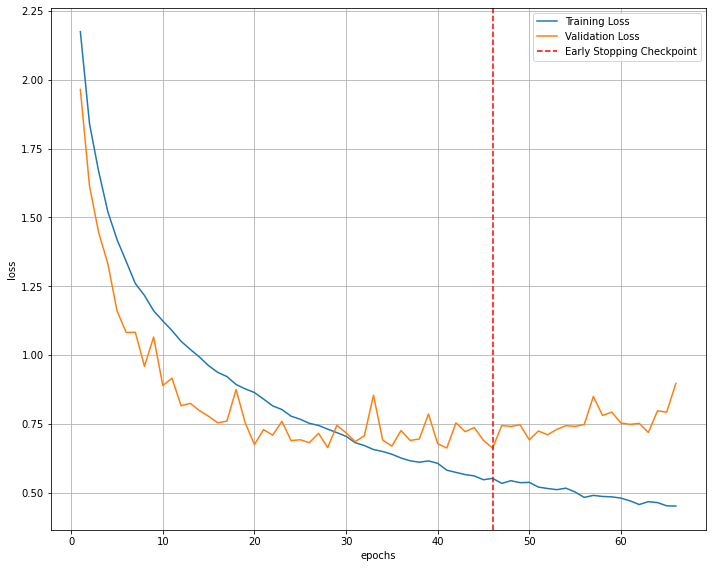

In [19]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

# test

In [20]:
def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 81.8%, Avg loss: 0.662225 



# make submission (but I couldn't submit it)

In [39]:
def make_file_list(path):
  file_list = list()
  path = path
  for file in sorted(glob(path + '*')):
    file_list.append(file)
  return file_list

file_list = make_file_list(path = './test/')

In [40]:
file_list[1]

'./test/0001.jpg'

In [41]:
class test_Dataset(data.Dataset):
  def __init__(self, file_list, transform):
    self.file_list = file_list
    self.transform = transform

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):
    img_path = self.file_list[index] # 데이터셋에서 파일 하나를 특정
    img = Image.open(img_path)
    img_transformed = self.transform(img)

    return img_transformed

In [42]:
test_dataset = test_Dataset(file_list=file_list, transform=ImageTransform())
test_dataloader = data.DataLoader(test_dataset, batch_size=512)

In [64]:
import pandas as pd

sample_submission = pd.read_csv('sample_submission.csv')

model.eval()

batch_index = 0

for i, images in enumerate(test_dataloader):
    images = images.to(device)
    outputs = model(images)
    batch_index = i * batch_size
    max_vals, max_indices = torch.max(outputs, 1)
    sample_submission.iloc[batch_index:batch_index + batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

In [65]:
sample_submission.head()

,id,target
0,0000.jpg,9
1,0001.jpg,2
2,0002.jpg,8
3,0003.jpg,9
4,0004.jpg,2


In [66]:
for i in sample_submission.index:
  sample_submission['target'][i] = get_key(sample_submission['target'][i])
# sample_submission['target'] = get_key(sample_submission['target'])
sample_submission.to_csv('dacon_object_1.csv', index=False)

In [67]:
sample_submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,airplane
2,0002.jpg,truck
3,0003.jpg,horse
4,0004.jpg,airplane
